# 3D Dissolved Oxygen Plotting

Shallow profilers on the cabled array oscillate up and down via a winch, collecting data along the way. If one were to plot such a profiler's depth over time during a sufficiently long time period, we would see a solid rectangle. By color-coding this x-y relationship with a third datatype (salinity, dissolved oxygen, etc.) we can produce a striking water-column profile of important chemical properties of the site.

## Data Request

Coming soon.

In [1]:
from yodapy.datasources import OOI
from yodapy.utils import set_credentials_file

ooi = OOI()
ooi.filter(region="cabled",site="oregon slope base shallow profiler",instrument="RS01SBPS-SF01A-2A-CTDPFA102")
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [3]:
begin = "2017-01-01"
end = "2017-03-01"
asset = ooi.request_data(
        begin_date = begin,
        end_date = end,
        data_type = "netcdf")

In [4]:
print(asset.raw()[0]["allURLs"])

['https://opendap.oceanobservatories.org/thredds/catalog/ooi/s-kganz@lwsd.org/20180716T223045-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html', 'https://opendap.oceanobservatories.org/async_results/s-kganz@lwsd.org/20180716T223045-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample']


In [5]:
xarr = asset.to_xarray()

In [6]:
frame = xarr[0].to_dataframe()

In [7]:
# convert netcdf to pandas data frame
import xarray as xr

#with xr.open_dataset("C:/users/ganzk/desktop/notebooks/dev_notebooks/keenan/test.nc") as d:
#with xr.open_dataset("big.nc") as d:
#    frame = d.to_dataframe()
frame["seawater_pressure"] = frame["seawater_pressure"].round()
frame = frame[["seawater_pressure","corrected_dissolved_oxygen"]]
print(frame.columns.values)

['seawater_pressure' 'corrected_dissolved_oxygen']


## Basic Plot

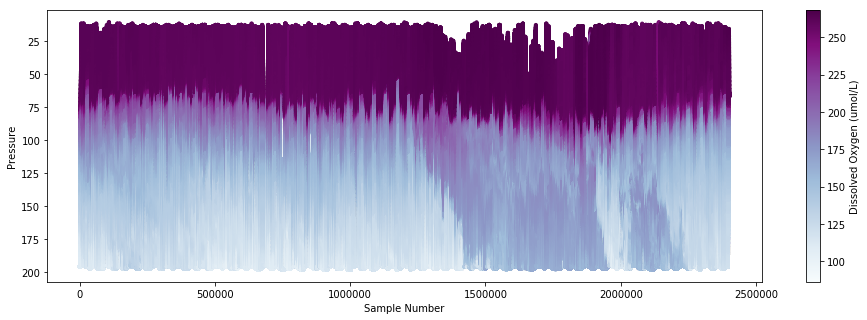

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# we are dealing with 7 million points here, the larger this number, cuts down plotting time
step = 1
fig = plt.figure(figsize=(16,5))
s = plt.scatter(frame.index[::step], # x
            frame["seawater_pressure"][::step], # y
            s=10, # thickness
            c=frame["corrected_dissolved_oxygen"][::step], # color map
            cmap=plt.get_cmap("BuPu")) # color style
# invert y to show more intuitive perspective
plt.gca().invert_yaxis()
plt.ylabel("Pressure")
plt.xlabel("Sample Number")
cb = plt.colorbar(s)
cb.set_label("Dissolved Oxygen (umol/L)")

Why the large white block in the middle of our data? If there is a connection issue between the profiler and the shore, the instrument will automatically stop oscillating. On rarer occasions, mechanical failure (likely the above) can cause longer outages). Fortunately, these holes are rare and do not prevent plotting the rest of the data.

## Depth Averaged

Above, we see a nice correlation between depth (synonym for pressure) and DO as we would expect. Although nice, what if there were an anomalous increase or decrease in DO at a particular depth that could harm marine life? To suss out this kind of information, we replot the data above but color-code it by comparing it to all other data points at the same depth.

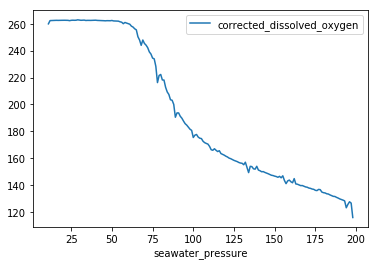

In [9]:
# group datapoints by depth
avgdo = frame.groupby("seawater_pressure").mean()["corrected_dissolved_oxygen"]
# how to show units?
avgdo.plot(y="corrected_dissolved_oxygen",legend=True)

In [10]:
# effectively a dictionary linking pressure with DO average
avgdo[20.0]

262.6140615659565

In [11]:
# runs fairly slow, any way to optimize?
def compute_diff(r):
    return r["corrected_dissolved_oxygen"] - avgdo[r["seawater_pressure"]]

frame2 = frame.apply(compute_diff,axis=1)

The cell below is helpful for making sure our color-coding does not bias towards either extreme by forcing pure white to align with zero variation from the mean.

In [12]:
from matplotlib.colors import Normalize as n
import numpy as np

maxmag = max(np.absolute(frame2))

# Note: norm is the CLASS that performs the normalization as opposed to the default generated by matplotlib
norm = n(vmin = -maxmag,vmax = maxmag)

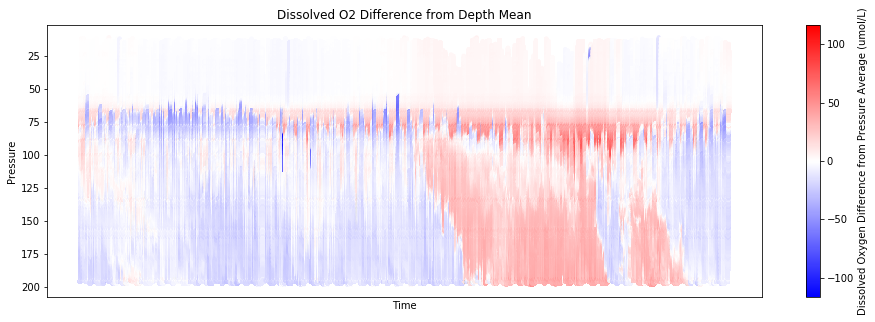

In [13]:
step = 1
fig = plt.figure(figsize=(16,5))
s = plt.scatter(frame.index[::step], # x
            frame["seawater_pressure"][::step], # y
            s=10, # thickness
            c=frame2[::step], # color map
            norm=norm,
            cmap=plt.get_cmap("bwr")) # color style
plt.gca().invert_yaxis()
plt.ylabel("Pressure")
plt.xlabel("Time")
plt.title("Dissolved O2 Difference from Depth Mean")
plt.tick_params(
    axis = "x",
    which="both",
    bottom = False,
    top = False,
    labelbottom=False)
cb = plt.colorbar(s)
cb.set_label("Dissolved Oxygen Difference from Pressure Average (umol/L)")

Although this depth-comparison doesn't show any sudden changes, it does reveal another interesting pattern: stripes! We see some interesting CRT-like scan lines that become more apparent towards the top of the plot.